In [ ]:
# import important packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from matplotlib import rcParams
import warnings

warnings.filterwarnings("ignore")

# figure size in inches
rcParams["figure.figsize"] = 10, 6
np.random.seed(42)

## 1. Load Dataset
- Load the `prime_indians_diabetes` dataset
- Check the first five samples. Are there any categorical features?
- Is this a classification or regression problem?
- Check the columns of the dataset

 There are  8 input variables and 1 output variable. Missing values are believed to be encoded with zero values. The variable names are as follows:

- Number of times pregnant.
- Plasma glucose concentration a 2 hours in an oral glucose tolerance test.
- Diastolic blood pressure (mm Hg).
- Triceps skinfold thickness (mm).
- 2-Hour serum insulin (mu U/ml).
- Body mass index (weight in kg/(height in m)^2).
- Diabetes pedigree function.
- Age (years).
- Class variable (0 or 1).

In [6]:
df = pd.read_csv('pima_indians_diabetes.csv')

df.head


<bound method NDFrame.head of      time_pregnant_no  plasma_concentration  diastolic_blood_pressure  \
0                   6                   148                        72   
1                   1                    85                        66   
2                   8                   183                        64   
3                   1                    89                        66   
4                   0                   137                        40   
..                ...                   ...                       ...   
763                10                   101                        76   
764                 2                   122                        70   
765                 5                   121                        72   
766                 1                   126                        60   
767                 1                    93                        70   

     triceps_skinfold_thickness  serum_insulin   bmi  diabetes_pedigree  age  \
0            

In [10]:
# Check the data types of each column
df.dtypes


time_pregnant_no                int64
plasma_concentration            int64
diastolic_blood_pressure        int64
triceps_skinfold_thickness      int64
serum_insulin                   int64
bmi                           float64
diabetes_pedigree             float64
age                             int64
class                           int64
dtype: object

In [11]:
# Check for unique values in the 'Class' column (which is the target variable)
df['class'].unique()

array([1, 0], dtype=int64)

In [13]:
# Check the distribution of the target variable (Class)
df['class'].value_counts()

class
0    500
1    268
Name: count, dtype: int64

In [14]:
# Check the column names in the dataset
df.columns

Index(['time_pregnant_no', 'plasma_concentration', 'diastolic_blood_pressure',
       'triceps_skinfold_thickness', 'serum_insulin', 'bmi',
       'diabetes_pedigree', 'age', 'class'],
      dtype='object')

In [15]:
# Check for zero values in the input columns
df[df == 0].count()


time_pregnant_no              111
plasma_concentration            5
diastolic_blood_pressure       35
triceps_skinfold_thickness    227
serum_insulin                 374
bmi                            11
diabetes_pedigree               0
age                             0
class                         500
dtype: int64

## 2. Data Preprocessing and Model
- Assign features to `X` and target variable to `y`
- Create a pipeline for preprocessing which includes imputing and standardscaling
- Create a pipeline for preprocessor and decision tree classifier.
- Tune up the model (adjust the max depth using grid search
- Train the model and make your predictions on the test dataset
- List the feature importance and the corresponding features
- Create a bar plot for the feature importances
- Drop the least important feature from the data and repeat the steps above

In [17]:
# Assign features to X and target to y
X = df.drop('class', axis=1)
y = df['class']


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Create a preprocessing pipeline
preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
    ('scaler', StandardScaler())  # Scale the features using StandardScaler
])

In [19]:
from sklearn.tree import DecisionTreeClassifier

# Create a full pipeline with preprocessing and a decision tree classifier
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Apply preprocessing steps
    ('classifier', DecisionTreeClassifier(random_state=42))  # Decision tree model
])


In [20]:
from sklearn.model_selection import GridSearchCV

# Set up the parameter grid for tuning max_depth
param_grid = {'classifier__max_depth': [3, 5, 7, 10, 15, None]}

# Create the grid search with cross-validation
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the model using grid search
grid_search.fit(X, y)

# Best parameters from grid search
print(f"Best parameters: {grid_search.best_params_}")


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'classifier__max_depth': 5}


In [ ]:
# Use the best model to make predictions
best_model = grid_search.best_estimator_

# Make predictions on the test data (assuming you have a test set)
y_pred = best_model.predict(X_test)

# Evaluate the model's performance (e.g., accuracy)
from sklearn.metrics import accuracy_score
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")


In [23]:
# Get feature importances
importances = best_model.named_steps['classifier'].feature_importances_

# Create a DataFrame for feature importances and corresponding feature names
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print feature importances
print(feature_importance_df)


                      Feature  Importance
1        plasma_concentration    0.490711
5                         bmi    0.220519
7                         age    0.137122
6           diabetes_pedigree    0.067679
2    diastolic_blood_pressure    0.041691
4               serum_insulin    0.031066
0            time_pregnant_no    0.011211
3  triceps_skinfold_thickness    0.000000


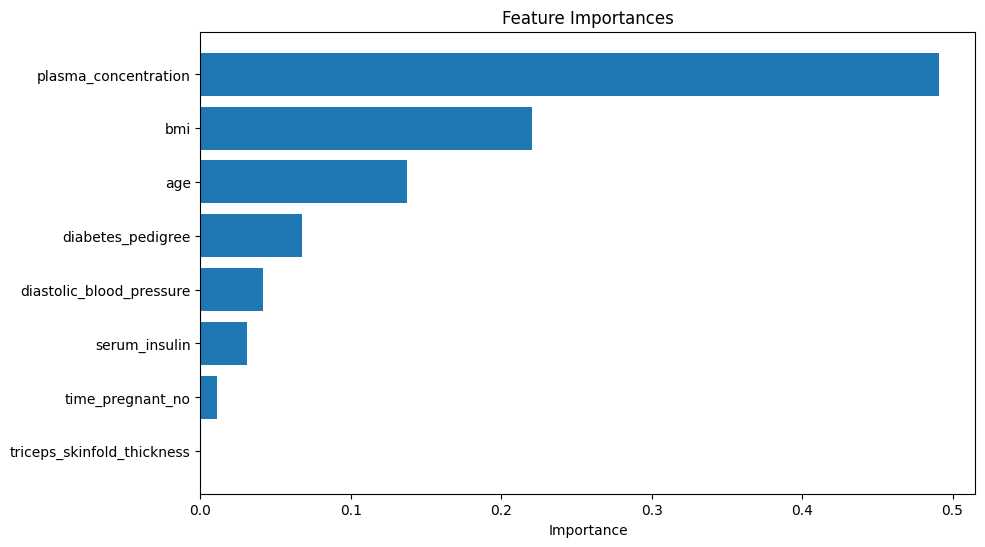

In [26]:
# Create a bar plot for feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # To have the most important feature at the top
plt.show()


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Test Accuracy after removing least important feature: 0.7597402597402597


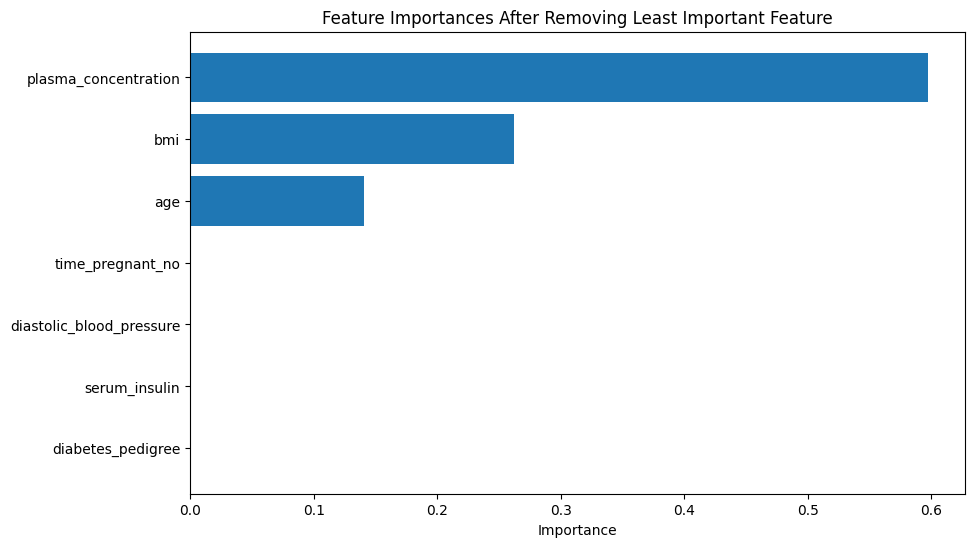

In [27]:
# Drop the least important feature
least_important_feature = feature_importance_df.tail(1)['Feature'].values[0]
X_reduced = X.drop(columns=[least_important_feature])

# Create a new pipeline for preprocessing and training
X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Repeat the same steps with the reduced dataset
grid_search.fit(X_train_reduced, y_train)
best_model_reduced = grid_search.best_estimator_

# Make predictions on the test data with the reduced feature set
y_pred_reduced = best_model_reduced.predict(X_test_reduced)

# Evaluate the model
print(f"Test Accuracy after removing least important feature: {accuracy_score(y_test, y_pred_reduced)}")

# Get and plot feature importances again
importances_reduced = best_model_reduced.named_steps['classifier'].feature_importances_
feature_importance_df_reduced = pd.DataFrame({
    'Feature': X_reduced.columns,
    'Importance': importances_reduced
}).sort_values(by='Importance', ascending=False)

# Plot the updated feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df_reduced['Feature'], feature_importance_df_reduced['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances After Removing Least Important Feature')
plt.gca().invert_yaxis()  # To have the most important feature at the top
plt.show()
